In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/home/jdli/transpec")

import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from transGaia.transgaia import xp2label
from transGaia.data import GXP_5lb
from matplotlib.colors import LogNorm
import cmasher as cmr

import matplotlib
from matplotlib import rcParams, rc
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd

rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 15
rcParams['font.family'] = 'sans-serif'
%config InlineBackend.figure_format = "retina"

cmap = cmr.dusk

In [2]:
from transGaia.vis import *
from transGaia.inference import *

data_dir = "/data/jdli/gaia/"
tr_file = "ap17_wise_xp_66701.npy"

device = torch.device('cuda:1')
TOTAL_NUM = 6000
BATCH_SIZE = 512

gdata  = GXP_5lb(
    data_dir+tr_file, total_num=TOTAL_NUM, 
    part_train=False,  device=device,
)
gdata_loader = DataLoader(gdata, batch_size=4096)

print(len(gdata))

66701


In [3]:
model_dir = "/data/jdli/gaia/model/1207_alpha/A/sp2_ALPHA_M_robustnorm_mse_A_ep200.pt"


model_a = xp2label(
    n_encoder_inputs=113, 
    n_outputs=1, 
    channels=128, 
    n_heads=8, attn=True, 
    n_layers=8).to(device)

model_a.load_state_dict(torch.load(model_dir))


<All keys matched successfully>

In [4]:
model_dir = "/data/jdli/gaia/model/1205_teff/A/sp2_teff_robustnorm_mse_A_ep200.pt"

model_t = xp2label(
    n_encoder_inputs=113, 
    n_outputs=1, 
    channels=128, 
    n_heads=8, attn=True, 
    n_layers=8).to(device)

model_t.load_state_dict(torch.load(model_dir))


<All keys matched successfully>

In [7]:
def predict_label_attn(data_loader, model, n_label=1, attn=True):
    out_lst = np.array([])
    # src_enc_lst = np.array([])
    # attn_all = np.array([])
    id_lst = []

    with torch.no_grad():

        for bs, data in tqdm(enumerate(data_loader)):
            
            id_batch =  list(np.int64(data['id']))
            for idl in id_batch:
                id_lst.append(idl)

            if attn:
                output, att, src_enc = model(data['x'])
                # print(att[0].shape)
                
                out_lst = np.append(out_lst, output.cpu().numpy())
                att_batch = np.array([a_lay.cpu().numpy() for a_lay in att]).reshape(8, -1, 113, 113) #(n_lay, bs, 113, 113)
                
                # att_batch = np.moveaxis(att_batch, [0], [1]) #(bs, n_lay, 113, 113)
                # attn_all = np.append(attn_all, att_batch)
                attn_all = np.concatenate((attn_all, att_batch), axis=1) if bs>0 else att_batch
                src_enc_lst = np.concatenate(
                    (src_enc_lst, src_enc.cpu().numpy()), axis=0) if bs>0 else src_enc.cpu().numpy()

                del output, data, att, src_enc
                
            else:
                output = model(data['x'])
                out_lst = np.append(out_lst, output.cpu().numpy())
                attn_all = None
                
                del output, data
                
    out_lst = np.array(out_lst).reshape(-1, n_label)

    return {'labels':out_lst, 'source_id':id_lst, 'attn':attn_all, 'src_enc':src_enc_lst}



In [8]:
aom_infer = predict_label_attn(gdata_loader, model_a)
teff_infer = predict_label_attn(gdata_loader, model_t)



17it [06:25, 22.70s/it]
17it [06:02, 21.32s/it]


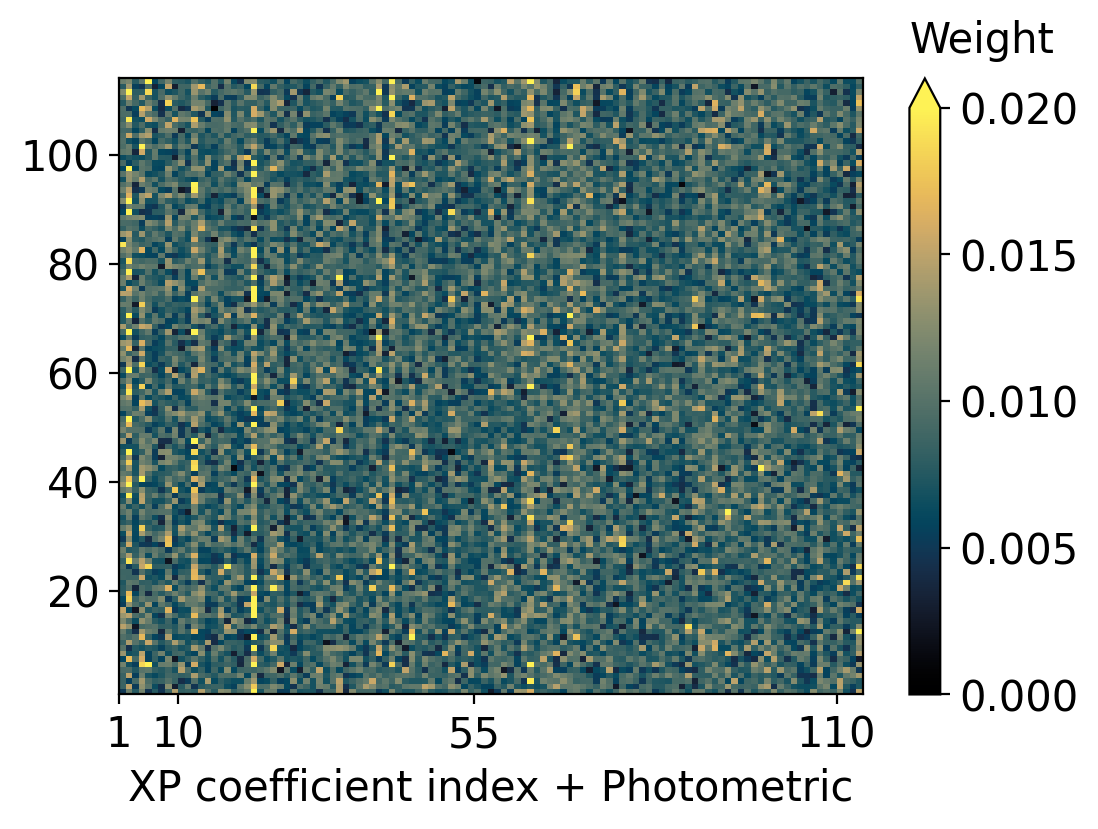

In [11]:
def draw_attention(attn, ax, vmax=0.03, cmap='cmr.eclipse'):
    num_coeff_grid = np.linspace(1,114,114)
    xx, yy = np.meshgrid(num_coeff_grid, num_coeff_grid)
    
    img = ax.pcolormesh(
        xx, yy, attn, 
        norm=colors.Normalize(vmin=0, vmax=vmax), 
        cmap=cmap, shading="flat"
    )
    # ax.set_xscale('log')
    ax.set_xticks([1, 10, 55, 110]);
    ax.set_xticklabels([1, 10, 55, 110]);

    clb = plt.colorbar(img, ax=ax, extend='max');
    clb.set_label(r"Weight", rotation=0, y=1.15, labelpad=-35)

    ax.set_xlabel("XP coefficient index + Photometric");
    return ax


fig, ax = plt.subplots(1,1,figsize=(6,4))

ax = draw_attention(aom_infer['attn'][2,0,:,:], ax, vmax=0.02)

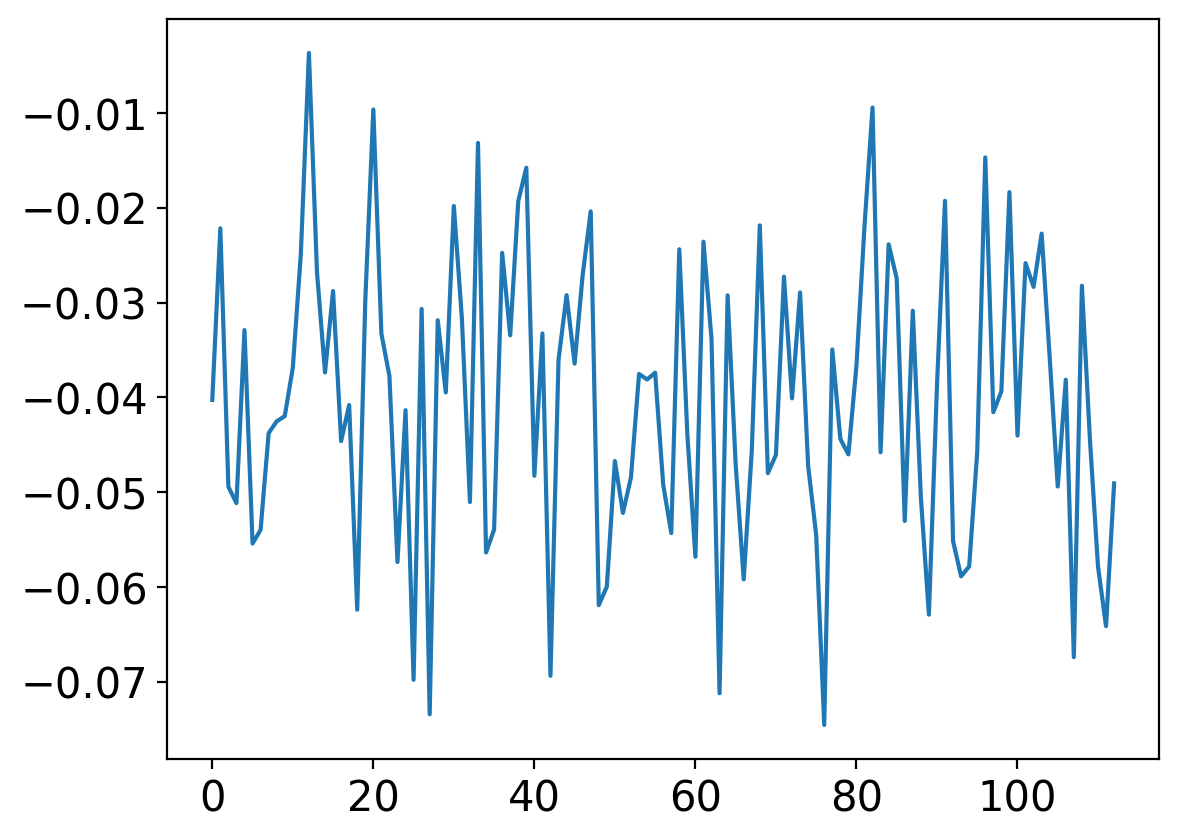

In [18]:
plt.plot(np.sum(teff_infer['src_enc'][0], axis=1))

In [18]:
ind = np.argpartition(np.sum(aom_infer['attn'][2,0,:,:], axis=0), -4)[-4:]


In [19]:
def get_sig_index(attn, num_max=5):
    
    return np.argpartition(np.sum(attn, axis=0), -num_max)[-num_max:]


get_sig_index(aom_infer['attn'][2,3,:,:])

array([98, 68, 61,  3, 20])

In [20]:
N_data  = 66701
n_layer = 8
num_max = 1

aom_sig_index  = np.ones([N_data, n_layer, num_max])
teff_sig_index = np.ones([N_data, n_layer, num_max])

for i in tqdm(range(N_data)):
    
    for j in range(n_layer):
        
        aom_sig_index[i,j,:]  = get_sig_index(aom_infer['attn'][j,i,:,:],  num_max=num_max)
        teff_sig_index[i,j,:] = get_sig_index(teff_infer['attn'][j,i,:,:], num_max=num_max)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66701/66701 [00:40<00:00, 1644.31it/s]


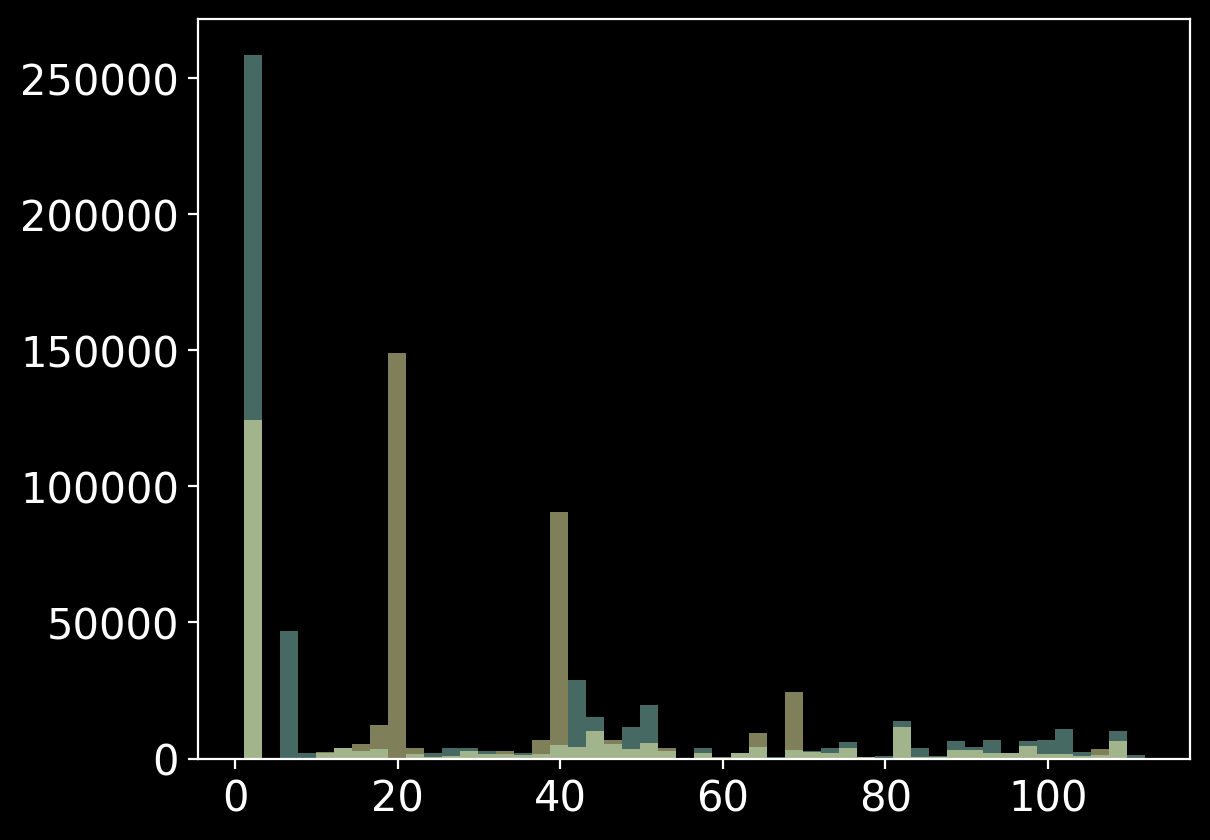

In [66]:
plt.hist(teff_sig_index.reshape(-1), alpha=0.5, bins=50);
plt.hist(aom_sig_index.reshape(-1), alpha=0.5, bins=50);


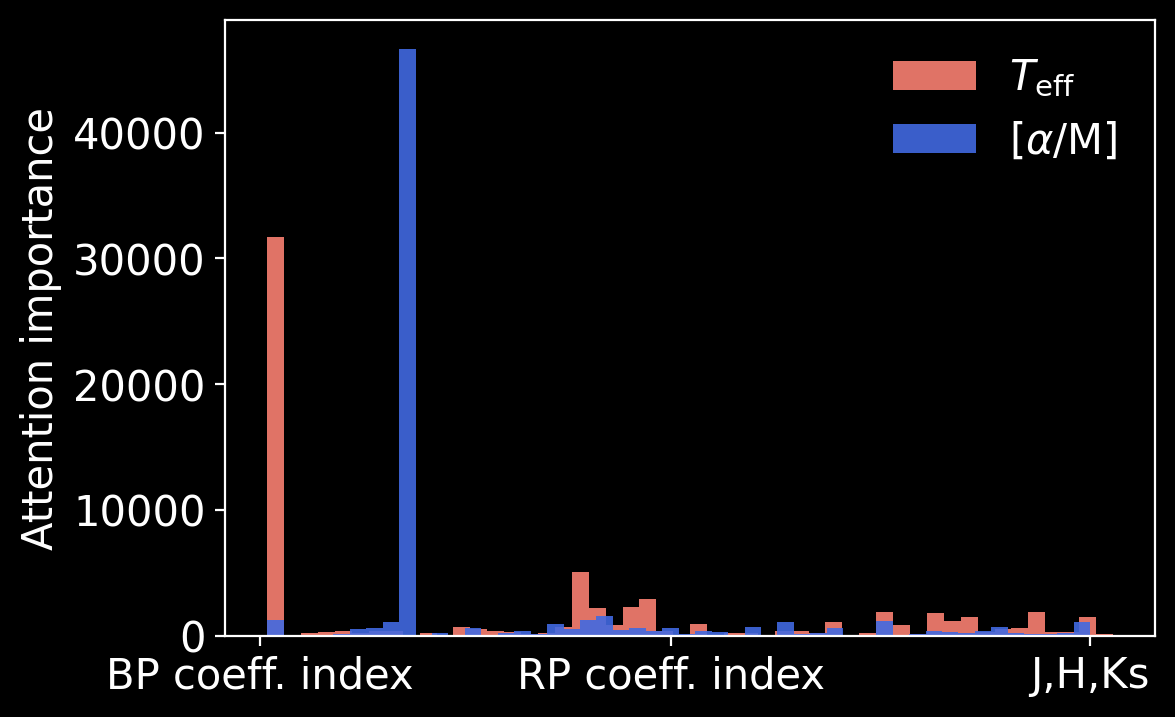

In [69]:
plt.style.use('dark_background')

idx_layer = 2
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.hist(teff_sig_index[:,idx_layer,:].reshape(-1), alpha=0.9, bins=50, color='salmon', label=r'$T_{\rm eff}$');
ax.hist(aom_sig_index[:,idx_layer,:].reshape(-1), alpha=0.9, bins=50, color='royalblue', label=r'[$\alpha$/M]');
# ax.set_xlabel('BP coeff. [0-54] index + RP coeff. index () + J,H,Ks');

ax.set_ylabel('Attention importance');
ax.set_xticks([0, 54, 109]);
ax.set_xticklabels(['BP coeff. index', 'RP coeff. index', 'J,H,Ks']);
ax.legend(frameon=False);
# ax.set_yscale('log')

In [150]:
from scipy import stats


stats.mode(aom_sig_index.reshape(-1))

/tmp/ipykernel_37596/1380048929.py:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  stats.mode(aom_sig_index.reshape(-1))


ModeResult(mode=array([20.]), count=array([149034]))

# Jensen-Shannon (JS) divergence

In [23]:
from scipy.spatial import distance

rng = np.random.default_rng(seed=42)

idx_total = np.arange(113)
idx_uni = rng.integers(0, 112, size=N_data)

In [49]:
n_lay = 1

teff_sig_1 = teff_sig_index[:, n_lay, 0].astype(np.int32)


In [102]:
# attn_teff_sum = np.sum(teff_infer['src_enc'][0], axis=1)[teff_sig_1[0]]

# idx_q = np.array([np.delete(idx_total, teff_sig_1[i], 0) for i in range(N_data)])
# idx_p = np.array([np.delete(idx_total, idx_uni[i], 0) for i in range(N_data)])

In [101]:
attn_teff_sum = np.sum(teff_infer['src_enc'], axis=2)


p = np.array([np.delete(attn_teff_sum[i], teff_sig_1[i], axis=0) for i in range(N_data)])
q = np.array([np.delete(attn_teff_sum[i], idx_uni[i], axis=0) for i in range(N_data)])

print(p.shape, q.shape)

(66701, 112) (66701, 112)


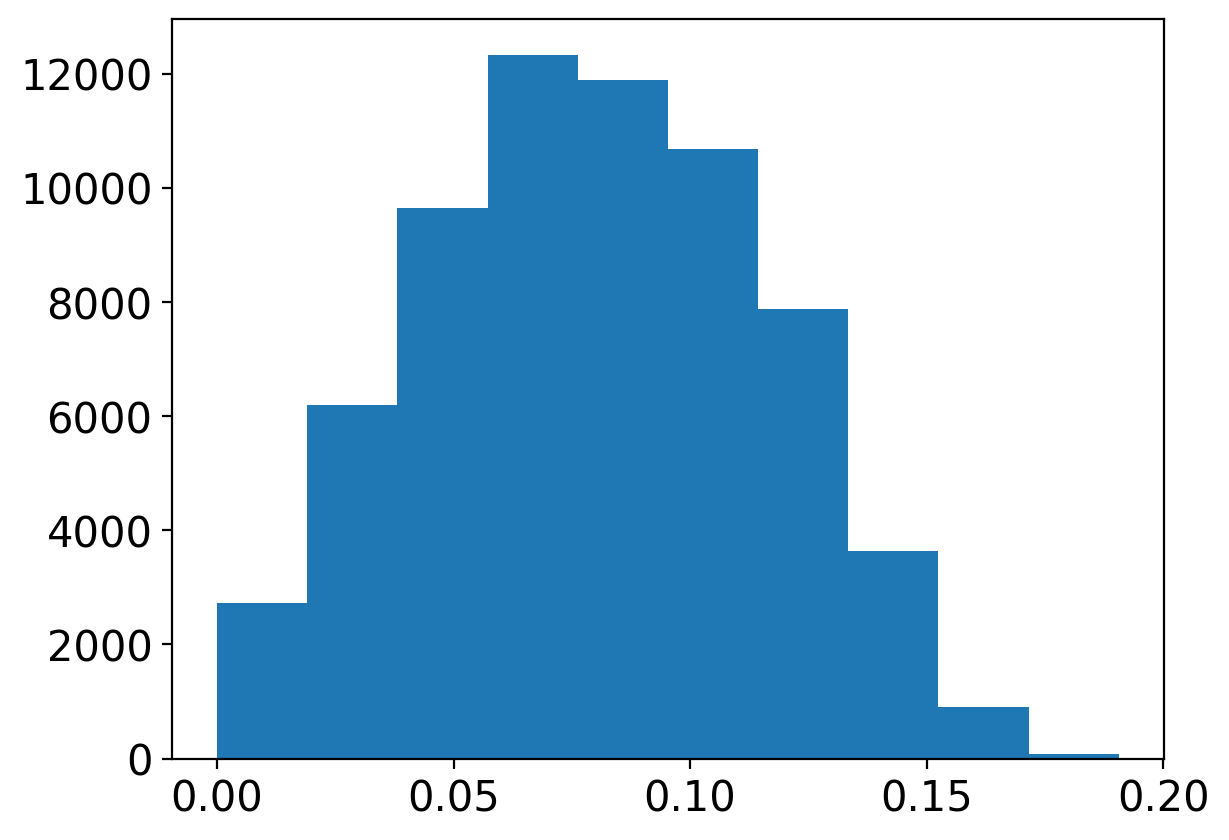

In [118]:
plt.hist(js_div[(js_div<10) & (js_div>0)]);


In [139]:
adf = pd.DataFrame({'source_id':teff_infer['source_id'], 'js':js_div})

gdf = pd.read_csv(data_dir+"ap17_gxp_train_81347.csv")

rdf = pd.merge(adf, gdf, on='source_id', )

print(rdf.shape)

(66701, 46)


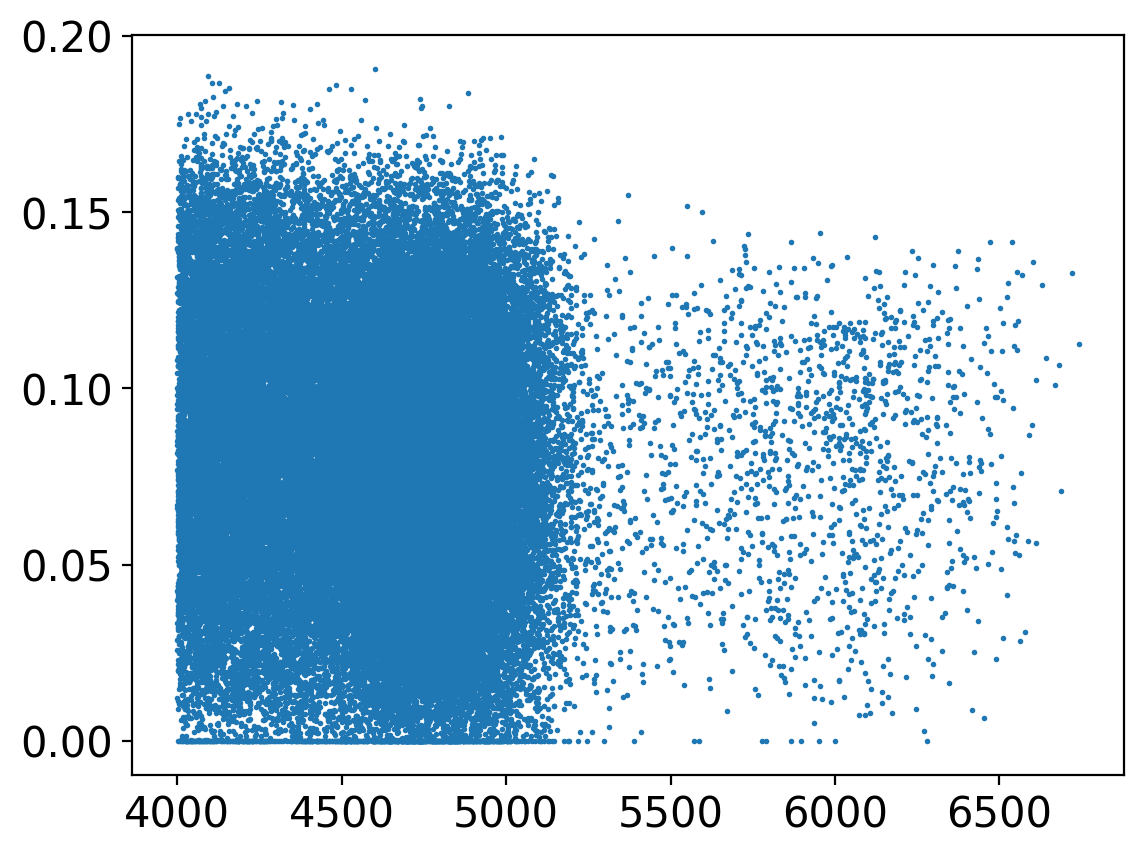

In [143]:
plt.scatter(rdf['TEFF'], rdf['js'], s=1)